Given a CPP: $X_t = \gamma t + \sum\limits_{j=1}^{N_t}Y_j$, where $N_t = N_{t-1} + \xi_t$, $p(\xi_t) = \lambda e^{-\lambda x}$

* $\gamma$ is drift
* $\lambda$ is intensivity
* $Y_1, Y_2, ..., Y_n \sim F$

According to Lebesque's Theoreme we can decompose $\nu$ - Levy measure:

$$\nu = \nu_d + \nu_{ac}$$, where $$\nu_d = \sum\limits_{j\in\mathcal{J}}g_j\delta_{J_j}$$


the only Levy processes for which the cumulative distribution
function of this measure exists are those whose jump component is a compound Poisson
process. 
$$N(t) := \lambda F(t) = \int\limits_{-\infty}^t\nu(dx)$$

Do measure actual weights of the jump measure $p = \frac{q}{\lambda}$

### Step 1. Model CPP

In [8]:
import random
import math
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

1) PP modeling

In [72]:
_lambda = 5
num_arrivals = 1000
arrival_time = 0


def get_pp_nt(_lambda, num_arrivals):
    nt_path = np.zeros(num_arrivals)
    pois_dist = st.poisson.rvs(size=num_arrivals-1, mu=_lambda)
    nt_path[1:] = np.cumsum(pois_dist)     
    return nt_path

In [73]:
nt_path = get_pp_nt(_lambda, num_arrivals)

2) CPP modeling

In [79]:
y_path = st.norm.rvs(loc=0, scale=10, size=int(nt_path[-1]))

In [80]:
def get_cpp_path(nt_path, y_path, gamma):
    assert len(y_path) == int(nt_path[-1])
    X_path = np.zeros(len(nt_path))
    for t in range(len(nt_path)):
        j = int(nt_path[t])
        X_path[t] = gamma*t + np.sum(y_path[:j])
    return X_path

In [81]:
X_path = get_cpp_path(nt_path, y_path, 2)

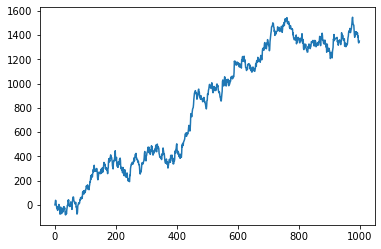

In [82]:
plt.plot(X_path);

### Step 2. Bulid estimation functions

We can observe X discrettly => we know only $X_{\Delta}, X_{2\Delta}, ..., X_{n\Delta}$, where $n=\frac{T}{\Delta}$

Thus $Z_k = X_{k\Delta} - X_{(k-1)\Delta}$ has independent increments

Derive $\phi(Z_k) = e^{\Delta(iu\gamma + \lambda \Phi_Y(u) - \lambda)} = e^{\Delta(iu\gamma + F\nu(u) - \lambda)}$

Build an estimator: $\frac{1}{\Delta} \int f(u) F^{-1} [ln(\phi)] du = \int f(u) \frac{1}{2\pi} [\int e^{-iux}(iu\gamma + F\nu(u) - \lambda) dx] du  = \gamma f'(0) - \lambda f(0) + \sum\limits_{j \in \mathbb{z}}f(J_j) + \int f d\nu_{ac}$

1) Solve inner integral:

I: $\frac{\gamma}{2\pi}\int e^{-iux}dx = \gamma \delta(0)$

II: $\frac{1}{2\pi} \int e^{-iux} F\nu(x) dx = \nu(u)$  (обратное преобразование фурье от преобразования фурье)

III: $\frac{\lambda}{2\pi}\int e^{-iux} dx = -\lambda \delta(x)$:

Мера Дирака:

$$\begin{equation*}
\delta(x) = 
 \begin{cases}
   1, & x = 0\\
   0 &\text{else}
 \end{cases}
\end{equation*}$$

Then we can estimate parametrs of process:

1) **$\lambda$ estimation**

We know that we can estimate $\phi(u)$ with the given outcomes of Z_k: $\hat\phi(u)=\frac{1}{n}\sum\limits_{k=1}^ne^{iuZ_k}$

$$\lambda = -\lim\limits_{n->\infty} \frac{1}{\Delta} \int_{\mathbb{R}}\mathbb{I}[|x| < \zeta_n]\mathcal{F}^{-1}(\ln(\phi(x))dx = \lim\limits_{n->\infty} \frac{1}{\Delta} \int_{\mathbb{R}}\mathbb{I}[|z| < \zeta_n] \frac{1}{2\pi}\int_{\mathbb{R}}e^{iux}\ln(\phi(x))dxdz $$

Simplify this formua for descrete case:

$$\hat\lambda = \Delta\int\limits_{-T}^T\mathcal{F}^{-1}(iux + \mathcal{F}\nu(x) - \lambda)dx=\Delta\int\limits_{-T}^T[\mathcal{F}^{-1}(iux  - \lambda) + \mathcal{F}\nu(x)] = \frac{\Delta}{2\pi} \int\limits_{-T}^T e^{-iux}(iux - \lambda)dx + \Delta\int\limits_{-T}^T\nu(x)dx= \frac{\Delta}{2\pi} \int\limits_{-T}^T (Cos(ux) - iSin(ux))(iux - \lambda)dx + \Delta\int\limits_{-T}^T\nu(x)dx = \frac{\Delta}{2\pi} [\int\limits_{-T}^T (Sin(ux)ux - Cos(ux)\lambda)dx + i\int\limits_{-T}^T (Cos(ux)ux + Sin(ux)\lambda)dx] + \Delta\int\limits_{-T}^T\nu(x)dx$$ (скорее всего не так понял)

**Скорее всего правильный вариант**: $$\hat\lambda = \int\limits_{-T}^Te^{-iux}\ln(\hat\phi(u))du = \int\limits_{-T}^T(Cos(ux)-i*Sin(ux))\ln[\frac{1}{n}\sum\limits_{k=1}^ne^{iuZ_k}]du$$

Представим $\ln[\frac{1}{n}\sum\limits_{k=1}^ne^{iuZ_k}]$ как комбинацию действительной и мнимой функции:

**Intensity estimation from PhD**:
1) Naive/direct estimator (log function of zero observation proportion): $$\tilde\lambda_n := -\frac{1}{\Delta}log(\frac{1}{n}\sum\limits_{k=1}^n\mathbb{I}_{\{0\}}(Z_k))$$

We can simplify this estimator buy caunting ratio of low increments $Z_k$

2) Complex estimator:

$\hat\lambda = \frac{1}{\Delta}\int\limits_\mathbb{R}\mathbb{I}_{[-H_n, H_n]\backslash(-\varepsilon_n, \varepsilon_n)}\mathcal{F}^{-1}[log(\mathcal{F}dG_n)\mathcal{F}K_{h_n}](x)dx$, where $\mathcal{F}dG_n = \frac{1}{n}\sum\limits_{k=1}^ne^{iZ_k}$


the probability of observing an instance of Z with no jumps is $e^{-\lambda\Delta}$. Let us
condition on the number of observations with jumps being $m \in \mathbb{N}$ and on the number of
non-zero such observations being $\tilde m \in \mathbb{N}$. Then, we have that:

$$\tilde\lambda_n = -\frac{1}{\Delta}log\frac{n-\tilde m}{n} =  -\frac{1}{\Delta}log\frac{n- m}{n}  -\frac{1}{\Delta}log\frac{n-\tilde m}{n - m}$$


if jumps can cancel out resulting in
zero observations, the second summand converges to a non-zero quantity and $\tilde\lambda_n$ cannotbe consistent


2) **$\gamma$ estimation**

$$\gamma = \lim\limits_{n->\infty} \frac{1}{\Delta} \int_{\mathbb{R}}x\mathbb{I}[|x| < \zeta_n]\mathcal{F}^{-1}(\ln(\phi(x))dx = \lim\limits_{n->\infty} \frac{1}{\Delta} \int_{\mathbb{R}}z\mathbb{I}[|z| < \zeta_n] \frac{1}{2\pi}\int_{\mathbb{R}}e^{iux}\ln(\phi(x))dxdz $$

3) **$q_j$ estimation**

$$ q_j = \lim\limits_{n->\infty} \frac{1}{\Delta} \int_{\mathbb{R}}x\mathbb{I}[|x - J_j|< \zeta_n]\mathcal{F}^{-1}(\ln(\phi(x))dx  $$

4) **$\int\limits_{-\infty}^t\nu_{ac}$ estimation**

$$\int\limits_{-\infty}^t\nu_{ac} = \lim\limits_{n->\infty} \frac{1}{\Delta} \int_{\mathbb{R}}\mathbb{I}[|x| \geq \zeta_n](1 - \sum\limits_{j\in \mathbb{Z}}\mathbb{I}[|x - J_j|< \zeta_n])\mathcal{F}^{-1}(\ln(\phi(x))dx$$

5) **$N(t)$ estimation**

$$N(t) =\lim\limits_{n->\infty} \frac{1}{\Delta} \int_{\mathbb{R}}\mathbb{I}[|x| \geq \zeta_n]\mathcal{F}^{-1}(\ln(\phi(x))dx $$

### Estimate lambda

In [83]:
def naive_lambda(X_path, upper_bound, delta=1):
    Z_k = X_path[1::2] - X_path[::2]
    return -delta*np.log((abs(Z_k) < upper_bound).sum()/len(Z_k))

In [84]:
naive_lambda(X_path, 0.5)

4.017383521085972

In [ ]:
def complex_int():
    pass


def real_int():
    pass

lambda = complex_int 

## Вопросы для следующей встречи:
1) Запутался с dx/du в формулах для оценки =>

2) Еще раз про вывод $\phi$

3) Как разложить ряд $\ln[\frac{1}{n}\sum\limits_{k=1}^ne^{iuZ_k}]$